# Explorary Data Analysis 1

We will perform EDA on the magnetic field data.

The features we might experiment on are:
- Raw signals @ Absolute Values
- Gradients
- Raw signals @ XYZ

The methodologies:
- DWT
- Windowing

TraviNavi
PeerNavi

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import api as magretraceapi
import scipy.signal as signal
from dtw import dtw
from scipy.spatial.distance import euclidean

In [2]:
api = magretraceapi.MagRetraceDataAPI("./data")

In [3]:
api.list_template_titles()
print()
api.list_traversal_titles()

Available template titles:
  0 - cb_g_exit_template_1_2023322_1146
  1 - cb_g_exit_template_2023322_1344
  2 - cb_g_exit_template_2_2023322_1147
  3 - cb_g_exit_template_2_2023322_1344
  4 - cb_g_exit_template_3_2023322_1148
  5 - cb_lg_exit_template_2023323_1225
  6 - composite_bldg_lg_exit_template_2023323_1226

Available traversal titles:
  0 - bonham_to_cross_cafe_2023322_1206
  1 - bonham_to_hku_campus_2023322_1256
  2 - cb_cbc_takecourse_2023321_1715
  3 - cbc_inner_traversal_2023322_1145
  4 - hw_1f_manydoors_2023322_1312
  5 - hw_take_lift_4f_1f_2023322_1309
  6 - main_bldg_traversal_2023322_1158
  7 - univ_street_exita_to_mainlib_2023322
  8 - univ_street_reverse_traversal_2023322_1304
  9 - univstreet_cb_enter_g_at_80s_2023324_1555


## 1. Exploring speciality of the template using DTW

In [4]:
from dtw import dtw
from scipy.spatial.distance import euclidean

def dtw_process(template, sequence):
    # Ensure that both arrays are 1-D
    template = np.reshape(template, (-1, 1))
    sequence = np.reshape(sequence, (-1, 1))

    # Define the distance function to use (Euclidean distance)
    distance = lambda x, y: euclidean(x, y)

    # Compute the DTW distance between the template and the sequence
    d, cost_matrix, acc_cost_matrix, path = dtw(template, sequence, dist=distance)

    # Extract the matching part of the sequence based on the DTW path
    start, end = path[0][1], path[-1][1]
    matched_sequence = sequence[start:end+1]

    return d, matched_sequence

In [5]:
def downsample(signal_time_seq: np.ndarray, signal: np.ndarray, downsample_factor) -> tuple[np.ndarray]:
    """
    Downsample the signal by the given factor.
    """
    # Compute the downsampled signal.
    signal_downsampled = signal[::downsample_factor]

    # Compute the downsampled time sequence.
    signal_time_seq_downsampled = signal_time_seq[::downsample_factor]

    return signal_time_seq_downsampled, signal_downsampled

In [6]:
import numpy as np
from typing import List

def sliding_window(sequence: np.ndarray, window_length: int, step: int) -> List[np.ndarray]:
    windows = []
    for i in range(0, len(sequence) - window_length + 1, step):
        window = sequence[i:i+window_length]
        windows.append(window)
    return windows

In [7]:
import scipy

def gaussian_filter(signal: np.ndarray, sigma: float):
    return scipy.ndimage.gaussian_filter(signal, sigma=sigma)

In [8]:
api.list_template_titles()
api.list_traversal_titles()

Available template titles:
  0 - cb_g_exit_template_1_2023322_1146
  1 - cb_g_exit_template_2023322_1344
  2 - cb_g_exit_template_2_2023322_1147
  3 - cb_g_exit_template_2_2023322_1344
  4 - cb_g_exit_template_3_2023322_1148
  5 - cb_lg_exit_template_2023323_1225
  6 - composite_bldg_lg_exit_template_2023323_1226
Available traversal titles:
  0 - bonham_to_cross_cafe_2023322_1206
  1 - bonham_to_hku_campus_2023322_1256
  2 - cb_cbc_takecourse_2023321_1715
  3 - cbc_inner_traversal_2023322_1145
  4 - hw_1f_manydoors_2023322_1312
  5 - hw_take_lift_4f_1f_2023322_1309
  6 - main_bldg_traversal_2023322_1158
  7 - univ_street_exita_to_mainlib_2023322
  8 - univ_street_reverse_traversal_2023322_1304
  9 - univstreet_cb_enter_g_at_80s_2023324_1555


In [40]:
# The template at the entrance of CB
tem = api.get_template_data(0)
tem_timeseq = tem.time_seq
tem_absmag = tem.mag_abs
tem_timeseq, tem_absmag = downsample(tem_timeseq, tem_absmag, 10)
tra = api.get_traversal_data(9)
tra_timeseq = tra.time_seq
tra_absmag = tra.mag_abs
tra_timeseq, tra_absmag = downsample(tra_timeseq, tra_absmag, 10)

tem_length = tem_absmag.shape[0]
window_length = round(tem_length)
window_step = tem_length // 2
windows = sliding_window(tra_absmag, window_length, window_step)
ds1 = []
for window in windows:
    d, matched_sequence = dtw_process(tem_absmag, window)
    ds1.append(d)


In [41]:
time_seq_idx = np.array([idx * window_step for idx in range(len(windows))])
sample_interval = tra_timeseq[1] - tra_timeseq[0]
time_seq = tra_timeseq[time_seq_idx]
time_seq

array([4.16816655e-03, 5.68036204e+00, 1.13565767e+01, 1.70327887e+01,
       2.27090120e+01, 2.83852375e+01, 3.40614763e+01, 3.97377335e+01,
       4.54139984e+01, 5.10902782e+01, 5.67665685e+01, 6.24428535e+01,
       6.81191468e+01, 7.37954393e+01, 7.94717302e+01, 8.51480201e+01,
       9.08243120e+01, 9.65006005e+01])

Text(0.5, 1.0, 'Window length:  11.45 s')

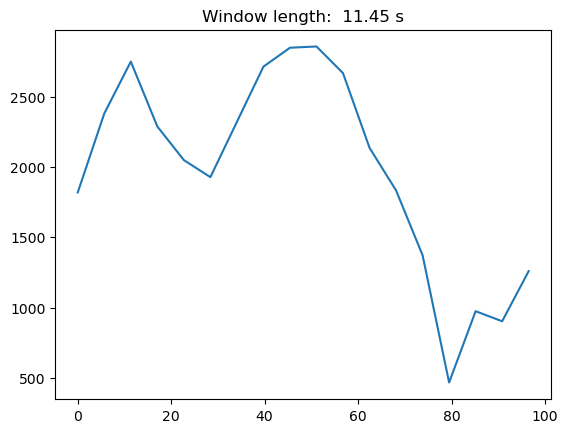

In [42]:
plt.plot(time_seq, ds1)
plt.title(f"Window length: {window_length * sample_interval: .2f} s")

In [17]:
api.get_template_data(0).time_seq

0        0.015344
1        0.025302
2        0.035260
3        0.045218
4        0.055176
          ...    
1145    11.417451
1146    11.427409
1147    11.437367
1148    11.447325
1149    11.457284
Name: Time (s), Length: 1150, dtype: float64

In [25]:
TEMPLATE_LEN = 11.45
print(27 * (TEMPLATE_LEN // 4), 27 * (TEMPLATE_LEN // 4) + TEMPLATE_LEN * 1.5)

54.0 71.175
